In [30]:
import nsaba
from nsaba.visualizer import NsabaVisualizer
from nsaba.geneinfo import gene_info
import pandas as pd
from scipy import stats
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Loading NS & ABA datafiles

data_dir = '../data_dir'
nsaba.Nsaba.aba_load(data_dir)
nsaba.Nsaba.ns_load(data_dir)

This may take a minute or two ...
SampleAnnot.csv loaded.
MicroarrayExpression.csv loaded.
Probes.csv loaded.
Nsaba.aba['mni_coords'] initialized.
database.txt loaded.
features.txt loaded.
Nsaba.ns['mni_coords'] initialized.


0

In [3]:
# Intializing Nsaba object and loading gene expression

tnsaba = nsaba.Nsaba()
tnsaba.load_ge_pickle('../data_dir/Nsaba_ABA_ge.pkl')

'ge' dictionary successfully loaded


In [241]:
tnsaba.is_term('reward')

True

In [295]:
# Setting term and Entrez IDs

term = 'reward'
gene = [1813] # D2 receptor: http://www.ncbi.nlm.nih.gov/gene/1813

In [18]:
# Generating estimated tf-idf coefficients

tnsaba.get_ns_act(term, thresh=-1)

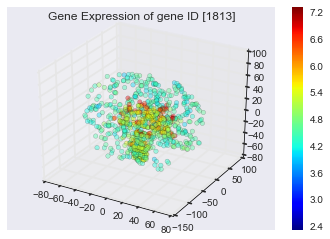

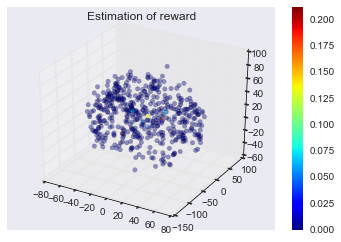

In [308]:
# Visualizing coefficient distribution

V = NsabaVisualizer(tnsaba)
V.visualize_ge(gene)
V.visualize_ns(term, points=500)

In [296]:
# Descriptive statistics of term and gene coefficients

analmat = tnsaba.make_ge_ns_mat(term, gene)
tsaba_df = pd.DataFrame(analmat)
tsaba_df.describe()

,0,1
count,893.000000,893.000000
mean,3.833284,0.010830
std,1.014421,0.024002
min,2.336206,0.000000
25%,3.092212,0.000000
50%,3.544095,0.001500
75%,4.322615,0.010190
max,7.341900,0.258155


In [297]:
# Hypothesis testing pre-processing
thres = .02

gt_thres = [row[0] for row in analmat if row[1] > thres]
lt_thres = [row[0] for row in analmat if row[1] <= thres]
len(gt_thres)

139

In [293]:
# Effect Size

def cohen_d(x1, x2, n1, n2):
    return (np.mean(x1) - np.mean(x2)) / np.sqrt( ((n1-1)*np.var(x1) + (n2-1)*np.var(x2)) / (n1 + n2 -2) )

In [298]:
# T-Test
print "t-value: %.4f \np-value: %.3E" % stats.ttest_ind(lt_thres, gt_thres)
print "Effect size: %.4f \n" % cohen_d(lt_thres,gt_thres,len(lt_thres),len(gt_thres))
# U-Test
print "Rank: %d \np-value: %.3E " % stats.mannwhitneyu(lt_thres, gt_thres)

t-value: -5.7098 
p-value: 1.541E-08
Effect size: -0.5278 

Rank: 41087 
p-value: 2.566E-05 


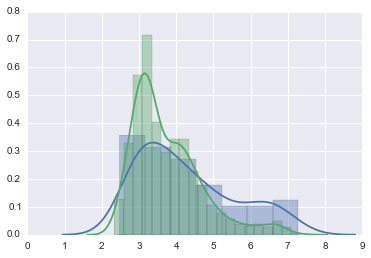

In [299]:
# Distributions of LT & GT thresholds

sns.distplot(gt_thres);
sns.distplot(lt_thres);

In [257]:
# Combining it all ...

def gene_term_ttest(gene, term, quant):
    analmat = tnsaba.make_ge_ns_mat(term, [gene])
    tsaba_df = pd.DataFrame(analmat)
    thres = tsaba_df.quantile(quant)[1]
    gt_thres = [row[0] for row in analmat if row[1] > thres]
    lt_thres = [row[0] for row in analmat if row[1] <= thres]
    # T-Test
    print "t-value: %.4f \np-value: %.3E" % stats.ttest_ind(lt_thres, gt_thres)
    print "Effect size: %.4f \n" % cohen_d(lt_thres,gt_thres,len(lt_thres),len(gt_thres))
    sns.distplot(gt_thres);
    sns.distplot(lt_thres);

t-value: -5.7401 
p-value: 1.297E-08
Effect size: -0.5386 



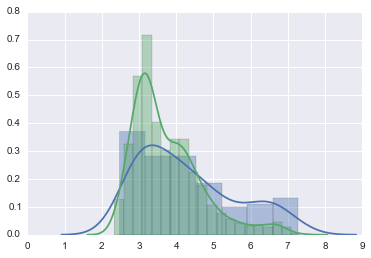

In [271]:
gene_term_ttest(1813, 'reward', .85)

In [185]:
# Setting term
term_ = 'reward'
tnsaba.get_ns_act(term_, thresh=-1)

In [274]:
# Finding smallest p-values across all Entrez IDs

## Parameters:
term = term_
sample_num = len(tnsaba.ge.keys())
top_id_return = 25
thres = pd.DataFrame(tnsaba.term[term]['ns_act_vector']).quantile(.85)[0]
##

if len(tnsaba.ge) < sample_num:
    raise ValueError("Sample number exceeds stored number of Entrez IDs")

aba_sam_num = len(tnsaba.ge[random.choice(tnsaba.ge.keys())])    
sam_ids = random.sample(tnsaba.ge.keys(), sample_num)
ge_mat = tnsaba.make_ge_ns_mat(term, sam_ids).T[:-1]

gene_p = []
for eid, ge in zip(sam_ids, ge_mat):
    gt_thres = [ge[i] for i in xrange(aba_sam_num) if tnsaba.term[term]['ns_act_vector'][i] > thres]
    lt_thres = [ge[i] for i in xrange(aba_sam_num) if tnsaba.term[term]['ns_act_vector'][i] <= thres]
    test_stats = stats.ttest_ind(lt_thres, gt_thres)
    d = cohen_d(lt_thres, gt_thres, len(lt_thres), len(gt_thres))
    if test_stats[0] <= 0:
        gene_p.append( (eid, d, test_stats[1]) )
    else:
        continue

# Sorting from greatest magnitude of effect size
gene_p.sort(key=lambda ge: ge[1])

In [275]:
top_genes = []
for i in xrange(top_id_return):
    try:
        top_genes.append( (gene_p[i][0], gene_p[i][1], gene_p[i][2], nsaba.geneinfo.gene_info(str(gene_p[i][0]))[0]) )
    except TypeError:
        continue
## Some ABA genes are not registered with NIH

This gene isn't registered with the NIH


In [276]:
alpha = .05
print "Corrected Bonferoni Alpha: %.3E\n\n" % (alpha/float(sample_num))
for eid, coh_d, p_val, descr in top_genes:
    if len(descr) == 1:
        print "%d (p = %.3E; d = %.3f): < No description found >\n\n" % (eid, p_val, coh_d)    
    else:
        print "%d (p = %.3E; d = %.3f): %s\n\n" % (eid, p_val, coh_d, descr)

Correct Bonferoni Alpha: 2.405E-06


3169 (p = 6.355E-13; d = -0.686): This gene encodes a member of the forkhead class of DNA-binding proteins. These hepatocyte nuclear factors are transcriptional activators for liver-specific transcripts such as albumin and transthyretin, and they also interact with chromatin. Similar family members in mice have roles in the regulation of metabolism and in the differentiation of the pancreas and liver. [provided by RefSeq, Jul 2008]


5445 (p = 3.014E-11; d = -0.632): < No description found >


25890 (p = 6.682E-11; d = -0.620): < No description found >


253970 (p = 6.935E-11; d = -0.620): < No description found >


23620 (p = 9.524E-11; d = -0.615): The protein encoded by this gene belongs to the G protein-coupled receptor family that activate a phosphatidylinositol-calcium second messenger system. Binding and pharmacological studies demonstrate that this receptor binds neurotensin as well as several other ligands already described for neurotensin 

Percent Significant (Bonferroni Correction; alpha = .05): 0.736 %


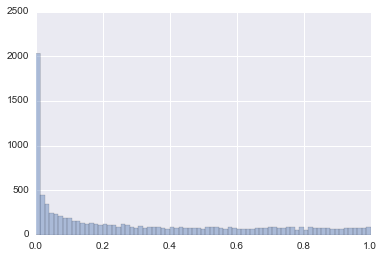

In [281]:
# Visualizing p-value distribution
p_vals = [p[2] for p in gene_p ]
sig = sum([ p < .05/sample_num for p in p_vals])
print "Percent Significant (Bonferroni Correction; alpha = .05): %.3f %%" % (100*sig/float(sample_num))
sns.distplot(p_vals, norm_hist=False, bins=75, kde=False);

In [ ]:
# Log-scale Visualization of p-values
plt.hist(p_vals, bins=np.logspace(-13, -1, 20));
plt.xscale('log')

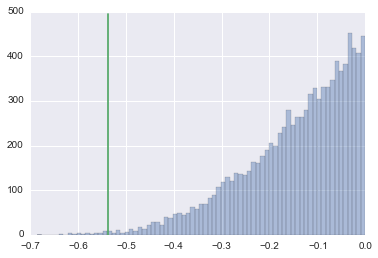

In [307]:
# Visualizing effect-size distribution
p_vals = [p[1] for p in gene_p ]
sns.distplot(p_vals, norm_hist=False, bins=75, kde=False);
sns.rugplot([-0.5386], height=495);
# Green line DRD2 effect size

In [284]:
p_less_than_d2 = sum([ p < 1.297E-08 for p in p_vals])
print " p-values less than DRD2 gene p-value: %.3f %%" % (100*p_less_than_d2/float(sample_num))

 p-values less than DRD2 gene p-value: 0.168 %
